In [1]:
!pip -q install "spikeinterface>=0.101" "spikeinterface[full,widgets]" pyarrow pandas scipy numpy
!pip -q install tridesclous || true

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os, math, numpy as np, pandas as pd
import spikeinterface as si
import spikeinterface.preprocessing as sp
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
from scipy.signal import welch
from IPython.display import display


In [3]:
recording = si.read_binary_folder('/content/drive/MyDrive/Neuro101DD/Data Analysis Workshop/rec1')

In [4]:
recording

BinaryFolderRecording: 1 channels - 22.0kHz - 125 segments - 13,750,125 samples 
                       625.01s (10.42 minutes) - float32 dtype - 52.45 MiB
Segments:
Samples:   110,001 | 110,001 | 110,001 | ... | 110,001 | 110,001 | 110,001
Durations: 5.00s | 5.00s | 5.00s | ... | 5.00s | 5.00s | 5.00s
Memory:    429.69 KiB | 429.69 KiB | 429.69 KiB | ... | 429.69 KiB | 429.69 KiB | 429.69 KiB

In [5]:
"""
si_plot_audio_utils.py

Utilities for visualizing, listening to, and spike-sorting single-channel, multi-segment
SpikeInterface recordings.

Contents
--------
Plotting:
- plot_segment(...)
- plot_concatenated(...)
- plot_segment_with_spikes_and_threshold_mad(...)

Audio:
- play_audio_segment(...)
- play_audio_concatenated_segments(...)

Spike sorting (Tridesclous) + metrics:
- run_tridesclous_sorting(...)
- compute_average_firing_rate(...)

Templates (via SortingAnalyzer):
- extract_templates_via_sorting_analyzer(...)
- plot_templates_from_array(...)
"""

from typing import Optional, Tuple
import warnings

import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.signal import resample_poly
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False
    resample_poly = None

# ------------------------------
# Helpers
# ------------------------------

def _assert_single_channel(recording):
    n_ch = recording.get_num_channels()
    if n_ch != 1:
        raise ValueError(f"This utility expects a single-channel recording; got {n_ch} channels.")


def _get_segment_samples(recording, segment_index: int) -> int:
    tr = recording.get_traces(segment_index=segment_index)
    return int(tr.shape[0])


def _downsample_for_plot(y: np.ndarray, max_points: int) -> tuple[np.ndarray, int]:
    n = y.shape[0]
    if n <= max_points:
        return y, 1
    step = int(np.ceil(n / max_points))
    return y[::step], step


def _median_and_mad(x: np.ndarray) -> Tuple[float, float]:
    """Return (median, MAD) where MAD = median(|x - median(x)|)."""
    med = float(np.median(x)) if x.size else 0.0
    mad = float(np.median(np.abs(x - med))) if x.size else 0.0
    return med, mad


# ------------------------------
# Plotting
# ------------------------------

def plot_segment(recording,
                 segment_index: int,
                 start_time: Optional[float] = None,
                 end_time: Optional[float] = None,
                 ax: Optional[plt.Axes] = None,
                 max_points: int = 500_000) -> plt.Axes:
    _assert_single_channel(recording)
    fs = float(recording.get_sampling_frequency())

    seg_n = _get_segment_samples(recording, segment_index)
    if start_time is None:
        start_time = 0.0
    if end_time is None:
        end_time = seg_n / fs
    if end_time <= start_time:
        raise ValueError("end_time must be greater than start_time")

    start_frame = int(np.clip(np.floor(start_time * fs), 0, seg_n))
    end_frame = int(np.clip(np.ceil(end_time * fs), start_frame, seg_n))

    tr = recording.get_traces(start_frame=start_frame, end_frame=end_frame, segment_index=segment_index)
    tr = np.asarray(tr).reshape(-1)
    t = np.arange(tr.shape[0], dtype=float) / fs + (start_frame / fs)

    y_ds, step = _downsample_for_plot(tr, max_points=max_points)
    t_ds = t[::step]

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))
    ax.plot(t_ds, y_ds, linewidth=0.8)
    ax.set_title(f"Segment {segment_index} ({start_time:.3f}s — {end_time:.3f}s)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.margins(x=0)
    return ax


def plot_concatenated(recording,
                      ax: Optional[plt.Axes] = None,
                      max_points: int = 1_000_000) -> plt.Axes:
    _assert_single_channel(recording)
    fs = float(recording.get_sampling_frequency())
    n_seg = int(recording.get_num_segments())

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 3))

    time_offset = 0.0
    total_samples = 0
    seg_lengths = []
    for seg in range(n_seg):
        seg_n = _get_segment_samples(recording, seg)
        seg_lengths.append(seg_n)
        total_samples += seg_n

    if total_samples == 0:
        warnings.warn("Recording appears to be empty.")
        return ax

    global_step = int(np.ceil(total_samples / max_points))
    global_step = max(global_step, 1)

    for seg, seg_n in enumerate(seg_lengths):
        tr = recording.get_traces(segment_index=seg).reshape(-1)
        y_ds = tr[::global_step]
        t_start = time_offset
        t_seg = t_start + (np.arange(y_ds.shape[0]) * (global_step / fs))
        ax.plot(t_seg, y_ds, linewidth=0.6)
        time_offset += seg_n / fs

    ax.set_title("Concatenated recording (all segments)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.margins(x=0)
    return ax


def plot_segment_with_spikes_and_threshold_mad(
        recording,
        sorting,
        segment_index: int,
        detect_threshold_mad: float,
        start_time: float | None = None,
        end_time: float | None = None,
        polarity: str = "neg",
        ax: Optional[plt.Axes] = None,
        max_points: int = 500_000) -> plt.Axes:
    """
    Plot a time window with spikes and a threshold derived from MAD units.

    detect_threshold_mad is converted to amplitude thresholds using the window's
    median and MAD:
        thr_neg = median - detect_threshold_mad * MAD
        thr_pos = median + detect_threshold_mad * MAD
    """
    fs = float(recording.get_sampling_frequency())
    _assert_single_channel(recording)

    if start_time is None:
        start_time = 0.0
    if end_time is None:
        seg_n = _get_segment_samples(recording, segment_index)
        end_time = seg_n / fs

    ax = plot_segment(recording, segment_index, start_time, end_time, ax=ax, max_points=max_points)

    start_frame = int(np.floor(start_time * fs))
    end_frame = int(np.ceil(end_time * fs))
    tr = recording.get_traces(start_frame=start_frame, end_frame=end_frame, segment_index=segment_index).reshape(-1)
    t = np.arange(tr.shape[0]) / fs + (start_frame / fs)

    med, mad = _median_and_mad(tr)
    thr_neg = med - detect_threshold_mad * mad
    thr_pos = med + detect_threshold_mad * mad

    if polarity in ("neg", "both"):
        ax.hlines(thr_neg, xmin=start_time, xmax=end_time, linestyles='--', linewidth=1.0, label=f'-{detect_threshold_mad:.2f} MAD')
    if polarity in ("pos", "both"):
        ax.hlines(thr_pos, xmin=start_time, xmax=end_time, linestyles='--', linewidth=1.0, label=f'+{detect_threshold_mad:.2f} MAD')

    unit_ids = sorting.get_unit_ids()
    spike_times_s = []
    for uid in unit_ids:
        st_frames = sorting.get_unit_spike_train(unit_id=uid, segment_index=segment_index)
        st_s = st_frames / fs
        mask = (st_s >= start_time) & (st_s <= end_time)
        spike_times_s.extend(list(st_s[mask]))

    if spike_times_s:
        y_at_spikes = np.interp(spike_times_s, t, tr)
        ax.scatter(spike_times_s, y_at_spikes, s=20, marker='x', label='spikes')

    ax.legend(loc='best')
    ax.set_title(f"Segment {segment_index} with spikes & ±{detect_threshold_mad} MAD threshold")
    return ax


# ------------------------------
# Audio
# ------------------------------

def play_audio_segment(recording,
                       segment_index: int,
                       start_time: float = 0.0,
                       duration: float = 30.0,
                       target_fs: int = 44100,
                       normalize: bool = True):
    from IPython.display import Audio

    _assert_single_channel(recording)
    fs = float(recording.get_sampling_frequency())
    seg_n = _get_segment_samples(recording, segment_index)

    if duration <= 0:
        raise ValueError("duration must be positive")

    start_frame = int(np.clip(np.floor(start_time * fs), 0, max(seg_n - 1, 0)))
    end_frame = int(np.clip(start_frame + int(np.round(duration * fs)), 0, seg_n))

    if end_frame <= start_frame:
        warnings.warn("Requested window is empty; returning silence.")
        data = np.zeros(int(target_fs * max(duration, 0.01)), dtype=np.float32)
        return Audio(data, rate=target_fs)

    tr = recording.get_traces(start_frame=start_frame, end_frame=end_frame, segment_index=segment_index)
    x = np.asarray(tr).astype(np.float32).reshape(-1)

    if x.size > 0:
        x = x - np.mean(x, dtype=np.float64)

    if int(round(fs)) != int(target_fs):
        if _HAS_SCIPY:
            import math
            g = math.gcd(int(round(fs)), int(target_fs))
            up = int(target_fs // g)
            down = int(round(fs) // g)
            x = resample_poly(x, up=up, down=down)
        else:
            t_in = np.linspace(0, 1, num=x.shape[0], endpoint=False)
            num_out = int(np.round(x.shape[0] * (target_fs / fs)))
            t_out = np.linspace(0, 1, num=num_out, endpoint=False)
            x = np.interp(t_out, t_in, x).astype(np.float32)

    if normalize:
        peak = np.max(np.abs(x)) if x.size else 1.0
        if peak > 0:
            x = 0.99 * (x / peak)

    return Audio(x, rate=int(target_fs))


def play_audio_concatenated_segments(recording,
                                     start_segment: int,
                                     n_segments: int = 5,
                                     gap_duration: float = 1.0,
                                     target_fs: int = 44100,
                                     normalize: bool = True):
    from IPython.display import Audio

    _assert_single_channel(recording)
    fs = float(recording.get_sampling_frequency())
    total_segments = int(recording.get_num_segments())

    if start_segment < 0 or start_segment >= total_segments:
        raise IndexError(f"start_segment {start_segment} out of range (0..{total_segments-1})")

    end_segment = min(start_segment + n_segments, total_segments)

    seg_arrays = []
    for seg in range(start_segment, end_segment):
        tr = recording.get_traces(segment_index=seg)
        x = np.asarray(tr).astype(np.float32).reshape(-1)
        if x.size > 0:
            x = x - np.mean(x, dtype=np.float64)
        seg_arrays.append(x)
        if seg < end_segment - 1 and gap_duration > 0:
            gap = np.zeros(int(round(gap_duration * fs)), dtype=np.float32)
            seg_arrays.append(gap)

    if not seg_arrays:
        return Audio(np.zeros(int(target_fs), dtype=np.float32), rate=target_fs)

    x = np.concatenate(seg_arrays)

    if int(round(fs)) != int(target_fs):
        if _HAS_SCIPY:
            import math
            g = math.gcd(int(round(fs)), int(target_fs))
            up = int(target_fs // g)
            down = int(round(fs) // g)
            x = resample_poly(x, up=up, down=down)
        else:
            t_in = np.linspace(0, 1, num=x.shape[0], endpoint=False)
            num_out = int(np.round(x.shape[0] * (target_fs / fs)))
            t_out = np.linspace(0, 1, num=num_out, endpoint=False)
            x = np.interp(t_out, t_in, x).astype(np.float32)

    if normalize:
        peak = np.max(np.abs(x)) if x.size else 1.0
        if peak > 0:
            x = 0.99 * (x / peak)

    return Audio(x, rate=int(target_fs))


# ------------------------------
# Spike sorting (Tridesclous) + metrics
# ------------------------------

def run_tridesclous_sorting(recording,
                            output_folder: str = "tdc_sort",
                            detect_threshold: float = 5.0,
                            **sorter_kwargs):
    _assert_single_channel(recording)

    try:
        import spikeinterface.full as si
    except Exception:
        import spikeinterface as si

    params = dict(detect_threshold=detect_threshold)
    params.update(sorter_kwargs)

    sorting = si.run_sorter(
        sorter_name="tridesclous",
        recording=recording,
        output_folder=output_folder,
        remove_existing=True,
        verbose=True,
        **params,
    )
    return sorting, params


def compute_average_firing_rate(sorting, recording) -> tuple[float, dict]:
    fs = float(recording.get_sampling_frequency())
    n_seg = int(recording.get_num_segments())

    total_samples = 0
    for seg in range(n_seg):
        total_samples += _get_segment_samples(recording, seg)
    total_duration = total_samples / fs if fs > 0 else 0.0
    if total_duration == 0:
        return 0.0, {}

    unit_ids = sorting.get_unit_ids()
    per_unit_hz = {}
    total_spikes = 0
    for uid in unit_ids:
        count = 0
        for seg in range(n_seg):
            st = sorting.get_unit_spike_train(unit_id=uid, segment_index=seg)
            count += int(len(st))
        per_unit_hz[uid] = count / total_duration
        total_spikes += count

    overall_hz = total_spikes / total_duration
    return overall_hz, per_unit_hz


# ------------------------------
# Templates via SortingAnalyzer
# ------------------------------

def extract_templates_via_sorting_analyzer(recording,
                                           sorting,
                                           folder: str | None = None,
                                           max_spikes_per_unit: int = 300,
                                           ms_before: float = 1.0,
                                           ms_after: float = 2.0):
    """
    Use SpikeInterface's SortingAnalyzer to compute and return average templates.
    Mirrors:
        sr1 = si.create_sorting_analyzer(sorting, recording)
        sr1.compute('random_spikes')
        sr1.compute('waveforms')
        sr1.compute('templates')
        av_templates = sr1.get_extension('templates').get_data(operator='average')
    """
    try:
        import spikeinterface.full as si
    except Exception:
        import spikeinterface as si

    sr1 = si.create_sorting_analyzer(sorting, recording, output_folder=folder, remove_if_exists=True)
    sr1.compute('random_spikes', max_spikes_per_unit=max_spikes_per_unit)
    sr1.compute('waveforms', ms_before=ms_before, ms_after=ms_after, return_scaled=True)
    sr1.compute('templates')

    templ_ext = sr1.get_extension('templates')
    av_templates = templ_ext.get_data(operator="average")
    av_templates = np.asarray(av_templates)
    unit_ids = list(sr1.sorting.get_unit_ids())

    if av_templates.ndim == 3 and av_templates.shape[1] == 1:
        av_templates = av_templates[:, 0, :]

    return av_templates, unit_ids


def plot_templates_from_array(templates: np.ndarray, unit_ids=None, ax: Optional[plt.Axes] = None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))

    T = templates
    if T.ndim == 3 and T.shape[1] >= 1:
        T = T[:, 0, :]
    if T.ndim != 2:
        raise ValueError(f"Unexpected template shape {templates.shape}; expected (n_units, n_samples) or (n_units, n_channels, n_samples).")

    n_units = T.shape[0]
    if unit_ids is None:
        unit_ids = list(range(n_units))

    for i in range(n_units):
        ax.plot(T[i], label=f"unit {unit_ids[i]}")
    ax.set_title("Unit templates (average)")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")
    if n_units <= 15:
        ax.legend(loc='best')
    return ax


<Axes: title={'center': 'Segment 1 (0.000s — 5.000s)'}, xlabel='Time (s)', ylabel='Amplitude'>

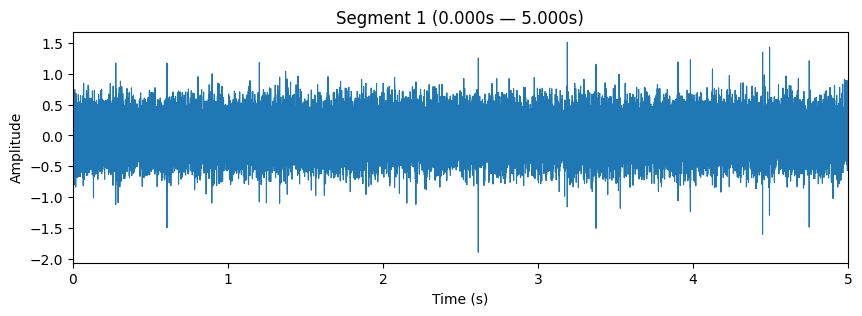

In [6]:
plot_segment(recording,segment_index = 1)

In [7]:
# --- CONFIG: set these for your workshop ---
WORKSHOP_NAME = "data101-workshop"
DATA_FOLDER_NAME = "data"               # where data will live locally
GDRIVE_FOLDER_ID = "1kKYpSFHBgthw3yuYveNbQiUVrLr-GE-G"  # Option A (leave "" to skip)
ZIP_HTTP_URL = ""  # e.g., a GitHub Release URL to a .zip file (Option B), or leave "" to skip
ZIP_FILENAME = "dataset.zip"            # only used if ZIP_HTTP_URL is set
GCS_HTTP_PREFIX = ""  # e.g., "https://storage.googleapis.com/your-bucket/workshop" (Option C), or leave "" to skip

# --- LOADER ---
import os, sys, shutil, subprocess, pathlib, zipfile

def _ensure(pkg):
    """Pip install a package if missing (quietly)."""
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

def _download_with_gdown(folder_id, dest):
    _ensure("gdown")
    import gdown
    os.makedirs(dest, exist_ok=True)
    # download folder (handles many files)
    gdown.download_folder(
        url=f"https://drive.google.com/drive/folders/{folder_id}",
        output=dest,
        quiet=False, use_cookies=False
    )

def _download_zip(url, zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    # Use curl if available (fewer issues than wget on some images)
    subprocess.check_call(["bash", "-lc", f'curl -L "{url}" -o "{zip_path}"'])
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_to)

def _maybe_copy_from_drive(source_rel, dest):
    """If student mounted Drive and placed data there, copy it once."""
    drive_path = "/content/drive/MyDrive"
    source = pathlib.Path(drive_path) / source_rel
    if source.exists():
        print(f"Copying data from Drive: {source}")
        if dest.exists():
            return
        shutil.copytree(source, dest)

def get_data_dir():
    """
    Returns a pathlib.Path to the local data directory.
    Strategy:
      1) If ./data already exists, use it.
      2) Else try copying from student's Google Drive at MyDrive/{WORKSHOP_NAME}/data.
      3) Else try Google Drive shared folder (gdown) if GDRIVE_FOLDER_ID is set.
      4) Else try ZIP_HTTP_URL (e.g., GitHub Release).
      5) Else, if GCS_HTTP_PREFIX is set, just return an HTTP prefix for on-demand reads.
    """
    data_dir = pathlib.Path("/content") / DATA_FOLDER_NAME

    # 1) already there?
    if data_dir.exists() and any(data_dir.iterdir()):
        print(f"Using existing data at {data_dir}")
        return data_dir

    # 2) try student's Drive copy (optional)
    try:
        from google.colab import drive  # only exists on Colab
        drive.mount("/content/drive", force_remount=False)
        _maybe_copy_from_drive(f"{WORKSHOP_NAME}/{DATA_FOLDER_NAME}", data_dir)
        if data_dir.exists() and any(data_dir.iterdir()):
            print(f"Using data copied from Drive at {data_dir}")
            return data_dir
    except Exception:
        pass  # not in Colab or not mounted

    # 3) try shared Google Drive folder via gdown
    if GDRIVE_FOLDER_ID:
        print("Downloading data from shared Google Drive folder...")
        _download_with_gdown(GDRIVE_FOLDER_ID, str(data_dir))
        if data_dir.exists() and any(data_dir.iterdir()):
            print(f"Data ready at {data_dir}")
            return data_dir

    # 4) try a ZIP URL (e.g., GitHub Release)
    if ZIP_HTTP_URL:
        print("Downloading data zip...")
        zip_path = pathlib.Path("/content") / ZIP_FILENAME
        _download_zip(ZIP_HTTP_URL, str(zip_path), str(data_dir))
        if data_dir.exists() and any(data_dir.iterdir()):
            print(f"Data ready at {data_dir}")
            return data_dir

    # 5) if using GCS HTTP prefix, return a virtual path (you'll read via HTTP)
    if GCS_HTTP_PREFIX:
        print("No local data; you set GCS_HTTP_PREFIX, so read directly via HTTP/streaming.")
        return pathlib.Path(GCS_HTTP_PREFIX)  # treat as a 'virtual' path

    raise RuntimeError(
        "Could not prepare data. Set one of: GDRIVE_FOLDER_ID, ZIP_HTTP_URL, or GCS_HTTP_PREFIX, "
        "or place data in /content/data before calling get_data_dir()."
    )

# Example convenience loader
def load_csv(name, **read_csv_kwargs):
    """
    Load a CSV named `name` (e.g., 'iris.csv').
    If using GCS_HTTP_PREFIX, this builds the HTTP URL instead of local path.
    """
    import pandas as pd
    base = get_data_dir()
    # If base looks like an HTTP prefix, assemble URL; else local path
    if str(base).startswith("http://") or str(base).startswith("https://"):
        url = f"{str(base).rstrip('/')}/{name}"
        print(f"Reading remotely: {url}")
        return pd.read_csv(url, **read_csv_kwargs)
    else:
        path = base / name
        print(f"Reading local: {path}")
        return pd.read_csv(path, **read_csv_kwargs)


In [8]:
from pathlib import Path

data_dir = get_data_dir()  # ensures data is present
print("Data directory:", data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Retrieving folder contents


Retrieving folder 1Oh_S8APAnO09jTpcyw5SV5AAQnSY9n19 recording1
Retrieving folder 15DdzcJsQnfGYFdsWamslXVWb5Ko5sOMU properties
Processing file 14YQyrXxVUrzA-E5WaTqVxCTNImHwmeoB location.npy
Processing file 1m-UgJe28c7tsVpdz15KN5AjXcFHPYw5s binary.json
Processing file 1Ek_X-ZyKAlT4HxF6xqF-His-jPU_trxT si_folder.json
Processing file 1ms_NRKOaGbFXoDxeF8Sfa5TIrGYxq1c7 traces_cached_seg0.raw
Processing file 1JfZQJ2qB2sl1Y_71SdP5Vvys8cbnGb5s traces_cached_seg1.raw
Processing file 1CFyp5g1t_8JwSNiNxlggDtX4Qw1Rs9nS traces_cached_seg2.raw
Processing file 1X_W5psvN7fhfVClYJxfvxSTWzBJPuAw_ traces_cached_seg3.raw
Processing file 1rFc_EFj6EmVHO0xIT0WomVSg3B3W5hqs traces_cached_seg4.raw
Processing file 1pS7BL6-3fXGg4QyDrHi5PSbGxKlpwcsU traces_cached_seg5.raw
Processing file 1vh5zKfvU0xRndT43d1oa02chii6FiFwy traces_cached_seg6.raw
Processing file 1pvynZaD1WtOg4wk0tO-N2xt0OD_HBKtP traces_cached_seg7.raw
Processing file 1KHYkM1CzIhlNbWMlVmNIOC52ADGPw2l5 traces_cached_seg8.raw
Processing file 17y9JPJFRl9

FolderContentsMaximumLimitError: The gdrive folder with url: https://drive.google.com/drive/folders/1Oh_S8APAnO09jTpcyw5SV5AAQnSY9n19?hl=en has more than 50 files, gdrive can't download more than this limit.